# Imports

In [230]:
# Usual stuff
import numpy as np
import matplotlib.pyplot as plt

# Scipy
import scipy as sp
import scipy.sparse as spr

# Typing
from typing import Callable

# Hamiltonian

We can now write the Hamiltonian including AFM and SC interaction as ([View more](https://www.notion.so/8-Superconducting-Instability-2a2b911af6a78021b002f7aad6a38266?pvs=21) - the SC is treated at the mean-field level):

$$
\begin{align*}

H &= \sum_{k=0}^{\pi/2} H_k

\end{align*}
$$

Where:

- $H_k$ couples the $\pm k$ modes with the $\pm k + \pi$ modes:
    
    $$
    \begin{align*}
    
    H_{k} &= H_k^\text{(HK + SC)} + H_{k+\pi}^\text{(HK + SC)}
    \\\\
    
    &\quad - J\sum_\sigma(n_{k\sigma} n_{k+\pi \bar \sigma} + n_{-k\sigma}n_{-k+\pi \bar \sigma})
    
    \end{align*}
    $$
    
- $H_k^\text{(HK + SC)}$  couples only the $\pm k$ modes:
    
    $$
    \begin{align*}
    
    H_k^\text{(HK + SC)}  &= \xi_k(n_k + n_{-k}) + U(n_{k\uarr}n_{k\darr} + n_{-k\uarr}n_{-k \darr})
    \\\\
    
    &\quad +\Delta^*(b_k + b_{-k}) + \Delta(b_k^\dag + b_{-k}^\dag)
    
    \end{align*}
    $$
    
- $b_k$ is the pair ladder operator for a Cooper pair:
    
    $$
    \begin{align*}
    
    b_k &= c_{-k\darr}c_{k\uarr}
    
    \end{align*}
    $$
    
- $\Delta$ has to be solved self-consistently for:
    
    $$
    \begin{align*}
    
    \Delta &= -\frac{g}{L_d}\sum_k\lang b_k\rang
    
    \end{align*}
    $$

We write the Hamiltonian in block-diagonal form, noticing that the number of particles pairs and the total spin are conserved, hence we get the following ten subspaces:
- **Parity of Particle Number**: Either $0$ or $1$.
- **Total Spin**: It is in the set $\pm4, \pm3, \pm2, \pm1, 0$.

## Helper Functions

In [231]:
def eps(kk: np.ndarray) -> np.ndarray:
    """
        Compute the dispersion relation for a given set of vectors `kk`.
    """
    return -2 * np.sum(np.cos(kk), axis = 0)


def fock(decimal: int, modes: int = 8) -> list[int]:
    return [(decimal >> n) % 2 for n in range(modes)][::-1]


# Sample code to convert from state to full fock space
# The four least significant bits (LSB) corresponds to k and the four MSBs corresponds to k+pi
state = 20
n_pk_ppi_u_i, n_pk_ppi_d_i, n_mk_ppi_u_i, n_mk_ppi_d_i, n_pk_npi_u_i, n_pk_npi_d_i, n_mk_npi_u_i, n_mk_npi_d_i = fock(state, 8)

We are using the basis:
$$
\begin{align*}
\ket{n_{k+\pi\uarr}, n_{k+\pi\darr}, n_{-k+\pi\uarr}, n_{-k+\pi\darr}, n_{k\uarr}, n_{k\darr}, n_{-k\uarr}, n_{-k\darr}}
\end{align*}
$$

## Subspaces

In [232]:
# CONSTANTS
MODES = 8
DIM = 2**MODES


# SUBSPACES
class Subspace:

    # Get properties and states
    # Technically we could even forget about the quantum numbers
    def __init__(self, parity: int, spin: int) -> None:
        # Quantum numbers of the subspace
        self.parity = parity
        self.spin = spin

        # States and dimension
        self.states = []
        self.dimension = 0
        self.Nk = 0

        # Lookup table
        self.lookup = dict()
    
    # Print
    def __str__(self) -> str:
        return f"Space with P = {self.parity} and S = {self.spin} contains {len(self.states)} states."

    
    # STATES
    
    # Add a state to the list
    def add_state(self, st: int) -> None:
        self.states += [st]

    # Build a lookup table {state: position} on the list
    def build_lookup(self) -> None:
        self.dimension = len(self.states)

        for index, st in enumerate(self.states):
            self.lookup[st] = index


    # OPERATORS

    # Create the operators
    def build_operators(self) -> tuple[np.ndarray, np.ndarray]:

        # Make sure we have a lookup table
        if len(self.lookup) == 0: self.build_lookup()

        # Operators (t for total, meaning both options)
        self.nk_tk_tpi_t = np.zeros((self.dimension, self.dimension), dtype=np.float64)
        self.bk_tk_tpi = np.zeros((self.dimension, self.dimension), dtype=np.float64)

        for st in self.states:
            # Position of the state
            ket = self.lookup[st]

            # Binary decomposition
            st_list = fock(st)
            n_pk_ppi_u, n_pk_ppi_d, n_mk_ppi_u, n_mk_ppi_d, n_pk_npi_u, n_pk_npi_d, n_mk_npi_u, n_mk_npi_d = st_list

            # Number of particles in the state
            self.nk_tk_tpi_t[ket, ket] = np.sum(st_list)

            # Applying bk to this state (st is the ket, we find the bra)
            if n_mk_npi_d * n_pk_npi_u:
                bra_pk_npi = self.lookup[st - 8 - 1]
                self.bk_tk_tpi[bra_pk_npi, ket] += (-1)**(n_pk_npi_u-1 + n_pk_npi_d + n_mk_npi_u)
            
            if n_pk_npi_d * n_mk_npi_u:
                bra_mk_npi = self.lookup[st - 4 - 2]
                self.bk_tk_tpi[bra_mk_npi, ket] += (-1)**(n_pk_npi_d)
            
            if n_pk_ppi_u * n_mk_ppi_d:
                bra_pk_ppi = self.lookup[st - 128 - 16]
                self.bk_tk_tpi[bra_pk_ppi, ket] += (-1)**(n_pk_ppi_u-1 + n_pk_ppi_d + n_mk_ppi_u)
            
            if n_pk_ppi_d * n_mk_ppi_u:
                bra_mk_ppi = self.lookup[st - 64 - 32]
                self.bk_tk_tpi[bra_mk_ppi, ket] += (-1)**(n_pk_ppi_d)
        
        # Debugging
        # print(f"For space (P, S) = ({self.parity}, {self.spin}) we have n given by:")
        # with np.printoptions(precision=3, suppress=True, threshold=100_000, linewidth=200):
        #     print(self.nk_tk_tpi_t)
            
        return self.nk_tk_tpi_t, self.bk_tk_tpi
            
        

    def build_hamiltonian(self, kk: np.ndarray, mu: float, U: float, Delta: complex, J: float) -> np.ndarray:

        # Number of k-points
        Nk = len(kk[0])
        self.Nk = Nk

        # Dispersion relation
        xi_npi = eps(kk) - mu
        xi_ppi = eps(kk + np.pi) - mu

        # Hamiltonian
        self.ham = np.zeros((Nk, self.dimension, self.dimension), dtype=np.float64)

        # Diagonal
        for st in self.states:
            # Position of the state
            ket = self.lookup[st]

            # Binary decomposition
            st_list = fock(st)
            n_pk_ppi_u, n_pk_ppi_d, n_mk_ppi_u, n_mk_ppi_d, n_pk_npi_u, n_pk_npi_d, n_mk_npi_u, n_mk_npi_d = st_list

            # Kinetic Energy
            self.ham[:, ket, ket] += xi_npi * np.sum(n_pk_npi_u + n_pk_npi_d + n_mk_npi_u + n_mk_npi_d)
            self.ham[:, ket, ket] += xi_ppi * np.sum(n_pk_ppi_u + n_pk_ppi_d + n_mk_ppi_u + n_mk_ppi_d)

            # HK Interaction
            self.ham[:, ket, ket] += U * (n_pk_ppi_u * n_pk_ppi_d + n_mk_ppi_u * n_mk_ppi_d + n_pk_npi_u * n_pk_npi_d + n_mk_npi_u * n_mk_npi_d)

            # AFM Interaction
            self.ham[:, ket, ket] += -J * (n_pk_npi_u * n_pk_ppi_d + n_mk_npi_u * n_mk_ppi_d + n_pk_npi_d * n_pk_ppi_u + n_mk_npi_d * n_mk_ppi_u)

        # Off-diagonal
        self.ham += np.conjugate(Delta) * self.bk_tk_tpi
        self.ham += Delta * np.transpose(np.conjugate(self.bk_tk_tpi))

        # with np.printoptions(precision=3, suppress=True, threshold=100_000, linewidth=200):
        #     print(f"The space is (P, S) = ({self.parity}, {self.spin})")

        #     print(f"The lookup table is:")
        #     print(self.lookup)

        #     print(f"The k-points are:")
        #     print(kk)

        #     print(f"The chemical potential is:")
        #     print(mu)

        #     print(f"The xi_npi is:")
        #     print(xi_npi)

        #     print(f"The xi_ppi is:")
        #     print(xi_ppi)

        #     print(f"The Hamiltonian is:")
        #     print(self.ham)

        return self.ham



def generate_fspace() -> dict[tuple[int, int], Subspace]:
    """
        Generate the Fock space for our problem.
    """

    # Create all spaces (types so we can have hints)
    fspace = dict[tuple[int, int], Subspace]()
    for parity in [0, 1]:
        for spin in range(-4, 5):
            # If we have an even number of particles then spin must be even
            if abs(spin) % 2 == parity:
                fspace[(parity, spin)] = Subspace(parity, spin)


    # STATES
    for st in range(DIM):

        # Compute parity
        parity = np.sum([(st >> n) % 2 for n in range(MODES)]) % 2

        # Compute spin
        spin = np.sum([(st >> (2*n + 1)) % 2 for n in range(MODES//2)]) - np.sum([(st >> (2*n)) % 2 for n in range(MODES//2)])

        # Add state to correct subspace
        fspace[(parity, spin)].add_state(st)

        # Debugging
        # print(f"(P, S) = ({parity}, {spin}) for state = {fock(st)}")



    # Build lookup tables
    # Check size of spaces, and that they add to the whole space
    maxi = 0
    total = 0
    for key in fspace:
        fspace[key].build_lookup()
        maxi = np.max([maxi, len(fspace[key].states)])
        total += len(fspace[key].states)

    return fspace

    print(f"Is the total number of states 256? {"Yes" if total == 256 else "No"}")
    print(f"The biggest space has {maxi} states.")

## Thermal Average

In [233]:
def thermal_average(fspace: dict[tuple[int, int], Subspace], eigen: dict[tuple[int, int], tuple[np.ndarray, np.ndarray]], opcode: str, T: float, E0) -> float:

    # Number of k-points
    Nk = fspace[(0, -4)].Nk

    # Partition function
    Z = np.zeros(Nk)
    bb = dict()
    for key in fspace:
        # Get eigenvalues and eigenvecs
        vals, vecs = eigen[key]

        # Get dimension
        dim = fspace[key].dimension

        # Minimum energy, to scale Boltzmann factors
        E0tile = np.tile(E0[:, None], (1, dim))
        vals = vals - E0tile

        # Boltzmann exponential
        bexp = np.exp(-vals/T)
        bb[key] = bexp

        # Compute partition function (sum over all dim states for each k)
        Z += np.sum(bexp, axis = 1)

    # Compute Boltzmann factor
    for key in eigen:
        # Get dimension
        dim = fspace[key].dimension

        # Divide by partition function
        Ztile = np.tile(Z[:, None], (1, dim))
        bb[key] /= Ztile
    
    # Compute average via a trace
    res = 0
    for key in fspace:
        
        # Get eigenvalues and eigenvecs
        vals, vecs = eigen[key]

        # Get dimension
        dim = fspace[key].dimension
        
        # Choose operator
        if opcode == "bk_tk_tpi":
            op = fspace[key].bk_tk_tpi
        elif opcode == "nk_tk_tpi_t":
            op = fspace[key].nk_tk_tpi_t
        
        # Choose Boltzman factor
        bfac = bb[key]

        for id in range(dim):
            # Build bra and ket
            bra = vecs[:, :, id]
            ket = bra.T
            bra = np.conjugate(ket)
            
            # Compute average (sum over axis=0 is expectation value, sum over axis=1 is over various k-points)
            res += np.sum(bfac[:, id] * bra * (op @ ket))

    return res

## Solving the Hamiltonian

In [234]:
def solve(L: int, d: int, mu: float, U: float, g: float, J: float, T: float, delta_start: float = 1e-3, delta_eps: float = 1e-4):
    """
        Solve the mean-field Hamiltonian for `L` k-points along each `d` directions for temperature `T` and chemical potential `mu`.

        Self-consistently compute Delta starting at `delta_start` with an error of `delta_eps`.
    """

    # Possible adjustments
    # Take out the [:-1] from kk
    # Change the kx > 0 into kx >= 0


    # OBTAINING K-POINTS

    # Determine values of k in our lattice
    kk = np.linspace(-np.pi, np.pi, L + 1)[:-1]

    # Make a mesh of k values
    grid_kk = np.meshgrid(*[kk]*d, indexing='ij')

    # Convert to a single array with shape (d, L ** d)
    mesh_kk = np.stack(grid_kk).reshape(d, len(kk) ** d)

    # Select only 0 <= kx <= np.pi/2
    mesh_kk = mesh_kk[:, (0 <= mesh_kk[0]) *  (mesh_kk[0] < np.pi/2)]

    # TODO: Compute the ek only once
    # Compute corresponding energies
    ee_npi = eps(kk)
    ee_ppi = eps(kk + np.pi)

    # Number of k-points
    Nk = len(mesh_kk[0])


    # SET UP FOCK SPACE

    # Generate the space
    fspace = generate_fspace()

    # Prepare the subspaces
    for key in fspace:
        fspace[key].build_operators()


    # SELF-CONSISTENT CALCULATION OF DELTA

    delta_error = delta_eps + 1
    while delta_error > delta_eps:
        
        # Solve the Hamiltonian
        E0 = np.zeros(Nk)
        eigen = dict()
        for key in fspace:

            # Generate Hamiltonian
            ham = fspace[key].build_hamiltonian(mesh_kk, mu, U, delta_start, J)

            # Diagonalize Hamiltonians
            vals, vecs = np.linalg.eigh(ham)

            # Save the results
            eigen[key] = (vals, vecs)
        
            # Compute minimum energy for each k-point
            E0 = np.minimum(E0, np.min(vals, axis=1))
            
        # Compute the component of delta for this subspace
        delta_new = thermal_average(fspace, eigen, "bk_tk_tpi", T, E0+1)
        
        delta_new *= -g / Nk

        # Compute error
        delta_error = np.abs(delta_start - delta_new)

        # Prepare next loop
        delta_start = delta_new
    

    # SOLVE FOR CONVERGED DELTA
    eigen = dict()
    for key in fspace:

        # Generate Hamiltonian
        ham = fspace[key].build_hamiltonian(mesh_kk, mu, U, delta_start, J)
        
        # Diagonalize Hamiltonians
        vals, vecs = np.linalg.eigh(ham)

        # Save the results
        eigen[key] = (vals, vecs)
    
        # Compute minimum energy for each k-point
        E0 = np.minimum(E0, np.min(vals, axis=1))

    n = thermal_average(fspace, eigen, "nk_tk_tpi_t", T, E0+1)

    # Normalize
    n /= (4 * Nk)

    return delta_start, n

In [235]:
# # PARAMETERS
# L = 1000
# d = 1
# U = 1
# mu = 0.5
# g = 1.5
# T = 0.01

# # Example CALCULATION
# Delta, n, Kxx, Jx = solve(L, d, U, mu, g, T)

## Phillips Plot

In [236]:
# # PARAMETERS
# L = 16
# d = 2
# T = 0.01


# # g SWEEP
# gg = [0.0, 1.5, 2.0, 3.0]

# # U SWEEP
# uu = [0.0, 12.0]

# # Calculations
# for U in uu:
#     for g in gg:

#         # MU SWEEP
#         mu_start = -2*d - U - g
#         mu_end = -mu_start
#         mu_steps = 100

#         mm = np.linspace(mu_start, mu_end, mu_steps+1)

#         nn = []
#         ss = []
#         for mu in mm:

#             # Solve the Hamiltonian
#             Delta, n, Kxx, Jx = solve(L, d, U, mu, g, T)

#             # Save the filling
#             nn += [n]

#             # Debugging:
#             # print(f"For U = {U: <4.1f}, g = {g: <4.1f} and mu = {mu: <6.2f} we have n = {n: <7.3f} Kxx = {Kxx: <9.5f} Jx = {Jx: <9.5f} and vals in range [{np.min(vals): <9.5f}, {np.max(vals): <9.5f}]")

#             # Save the superfluid stifness
#             ss += [Kxx - Jx]
            
#         plt.plot(nn, ss, label=f"U = {U} and g = {g}")

# plt.title(f"Filling (L = {L}, d = {d}, T = {T})")
# plt.xlabel("Filling")
# plt.ylabel("Kinetic Energy")
# plt.legend(bbox_to_anchor=(1.1, 1.05))

## Filling $n(\mu)$ for a 1D Tight-Binding Chain

In [237]:
# # PARAMETERS
# L = 1000
# d = 1
# U = 0
# g = 0.1
# T = 0.01


# # MU SWEEP
# mu_start = -2*d - U
# mu_steps = 30
# mu_eps = 0.1

# # Find new mu_start
# mu_error = 1
# while mu_error > mu_eps:
#     # Solve the Hamiltonian
#     Delta, n, Kxx, Jx, vals = solve(L, d, U, mu_start, g, T)

#     print(f"For U = {U: <4.1f}, g = {g: <4.1f} and mu = {mu_start: <6.2f} we have n = {n: <7.3f} Kxx = {Kxx: <9.5f} Jx = {Jx: <9.5f} and vals in range [{np.min(vals): <9.5f}, {np.max(vals): <9.5f}]")

#     # Compare range of energies with chosen mu (divide each eigenvalue per 4 particles and then shift by 1/2)
#     mu_new = -0.5 * np.real(np.max(vals) / 4)

#     # Compute error and prepare next iteration
#     mu_error = np.abs(mu_start - mu_new)
#     mu_start = mu_new


# print(f"Converged for mu = {mu_start:.4f}")


# # Calculations
# mm = np.linspace(mu_start, -mu_start, mu_steps+1)
# nn = []
# for mu in mm:

#     # Solve the Hamiltonian
#     Delta, n, Kxx, Jx, vals = solve(L, d, U, mu, g, T)
    
#     # Save the filling
#     nn += [n]

# plt.title(f"Filling (L = {L}, d = {d}, U = {U}, g = {g}, T = {T})")
# plt.ylabel("Filling")
# plt.xlabel("Chemical Potential / t")
# plt.plot(mm, nn, label="Calculations")
# plt.plot(mm, (2 / np.pi) * np.arccos(-0.5 * mm), label="Theory")
# plt.legend()

## Filling $n(\mu)$ for a 1D Tight-Binding Chain

Done mu nº1.
Done mu nº2.
Done mu nº3.
Done mu nº4.
Done mu nº5.
Done mu nº6.
Done mu nº7.
Done mu nº8.
Done mu nº9.
Done mu nº10.
Done mu nº11.
Done mu nº12.
Done mu nº13.
Done mu nº14.
Done mu nº15.
Done mu nº16.
Done mu nº17.
Done mu nº18.
Done mu nº19.
Done mu nº20.
Done mu nº21.
Done mu nº22.
Done mu nº23.
Done mu nº24.
Done mu nº25.
Done mu nº26.
Done mu nº27.
Done mu nº28.
Done mu nº29.
Done mu nº30.
Done mu nº31.
Done mu nº32.
Done mu nº33.
Done mu nº34.
Done mu nº35.
Done mu nº36.
Done mu nº37.
Done mu nº38.
Done mu nº39.
Done mu nº40.
Done mu nº41.
Done mu nº42.
Done mu nº43.
Done mu nº44.
Done mu nº45.
Done mu nº46.
Done mu nº47.
Done mu nº48.
Done mu nº49.
Done mu nº50.
Done mu nº51.
Done mu nº52.
Done mu nº53.
Done mu nº54.
Done mu nº55.
Done mu nº56.
Done mu nº57.
Done mu nº58.
Done mu nº59.
Done mu nº60.
Done mu nº61.
Done mu nº62.
Done mu nº63.
Done mu nº64.
Done mu nº65.
Done mu nº66.
Done mu nº67.
Done mu nº68.
Done mu nº69.
Done mu nº70.
Done mu nº71.
Done mu nº72.
D

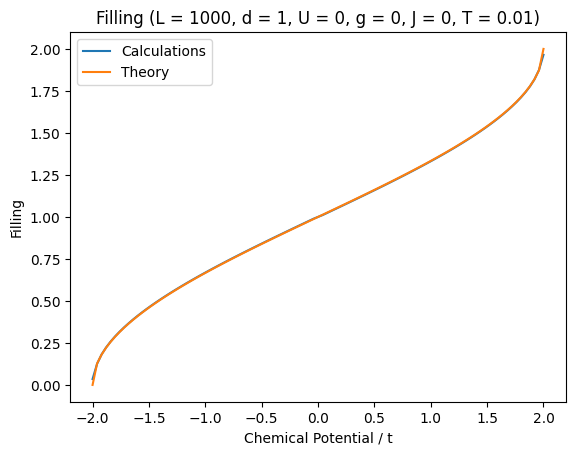

In [238]:
# PARAMETERS
L = 1000
d = 1
U = 0
g = 0
J = 0
T = 0.01


# MU SWEEP
mu_start = -2*d - U
mu_end = -mu_start
mu_steps = int(L/10)


# Calculations
mm = np.linspace(mu_start, mu_end, mu_steps+1)
nn = []
for mu in mm:

    # Solve the Hamiltonian
    Delta, n = solve(L, d, mu, U, g, J, T)

    # Save the filling
    nn += [n]

    print(f"Done mu nº{len(nn)}.")

print(np.average(nn), np.std(nn))

plt.title(f"Filling (L = {L}, d = {d}, U = {U}, g = {g}, J = {J}, T = {T})")
plt.ylabel("Filling")
plt.xlabel("Chemical Potential / t")
plt.plot(mm, nn, label="Calculations")
plt.plot(mm, (2 / np.pi) * np.arccos(-0.5 * mm), label="Theory")
plt.legend()
plt.show()

## Previous Attempt - Hamiltonian with SymPy

In [239]:
'''
# We are using the notation npku as "n plus k up"
def ham():
    """
        Create the Hamiltonian Hk symbolically.
    """

    # Dimension of the Fock space
    dim = 16

    # Build the Hamiltonian
    Hk = sp.zeros(dim, dim)

    # Symbols
    xi, U, Delta = sp.symbols("xi, U, Delta")
    Delta_star = sp.conjugate(Delta)
    
    # Diagonal terms
    for i in range(dim):
        npku, npkd, nmku, nmkd = fock(i)
        Hk[i, i] += xi * (npku + npkd + nmku + nmkd)
        Hk[i, i] += U * (npku * npkd + nmku * nmkd)
    
    # Off-diagonal terms, taking into account the phase factor!
    # I will do only the destruction terms, as the creation ones are obtained by conjugation.
    for i in range(dim):
        for j in range(dim):
            npkui, npkdi, nmkui, nmkdi = fock(i)
            npkuj, npkdj, nmkuj, nmkdj = fock(j)

            Hk[i, j] += Delta_star * ((-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (npkdi == npkdj) * (nmkui == nmkuj) + 
                                      (-1)**(npkdj) * ((nmkui + 1) == nmkuj) * ((npkdi + 1) == npkdj) * (npkui == npkuj) * (nmkdi == nmkdj))
    
    # Hermitian conjugate
    for i in range(dim):
        for j in range(dim):
            if i != j and Hk[j, i] == 0:
                Hk[j, i] += sp.conjugate(Hk[i, j])
    
    return Hk


def solve(N: int, d: int, U: float, mu: float):
    """
        Solve the mean-field Hamiltonian for N k-points along each d directions.
    """

    # Get the Hamiltonian
    Hk = ham()

    print("Hamiltonian:")
    print(sp.latex(Hk))

    # Diagonalize the Hamiltonian
    (vecs, vals) = Hk.diagonalize(sort=True, normalize=True)

    print("\nEigenvectors:")
    print(sp.latex(vecs))
    print(sp.latex(vals))

    print("\nEigenvectors in string form:")
    print(str(vecs))
    print(str(vals))

'''

'\n# We are using the notation npku as "n plus k up"\ndef ham():\n    """\n        Create the Hamiltonian Hk symbolically.\n    """\n\n    # Dimension of the Fock space\n    dim = 16\n\n    # Build the Hamiltonian\n    Hk = sp.zeros(dim, dim)\n\n    # Symbols\n    xi, U, Delta = sp.symbols("xi, U, Delta")\n    Delta_star = sp.conjugate(Delta)\n    \n    # Diagonal terms\n    for i in range(dim):\n        npku, npkd, nmku, nmkd = fock(i)\n        Hk[i, i] += xi * (npku + npkd + nmku + nmkd)\n        Hk[i, i] += U * (npku * npkd + nmku * nmkd)\n    \n    # Off-diagonal terms, taking into account the phase factor!\n    # I will do only the destruction terms, as the creation ones are obtained by conjugation.\n    for i in range(dim):\n        for j in range(dim):\n            npkui, npkdi, nmkui, nmkdi = fock(i)\n            npkuj, npkdj, nmkuj, nmkdj = fock(j)\n\n            Hk[i, j] += Delta_star * ((-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (np

Result:

$$
\left[\begin{array}{cccccccccccccccc}0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & \overline{\Delta} & 0 & 0 & 0 & 0 & 0 & 0\\0 & \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & 0 & 0\\0 & 0 & 0 & U + 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0\\0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\- \Delta & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \overline{\Delta}\\0 & - \Delta & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0\\\Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta}\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0\\0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 2 \xi & 0 & 0 & 0\\0 & 0 & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0\\0 & 0 & 0 & 0 & 0 & 0 & \Delta & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 2 U + 4 \xi\end{array}\right]
$$